# Курсовой проект для курса "Python для Data Science"

#### Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

#### Целевая переменная:
Price

#### Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

#### Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

#### Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.


#### Описание датасета:
Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [135]:
TEST_DATASET_PATH = "test.csv"
TRAIN_DATASET_PATH = "train.csv"

In [136]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


#### Уменьшаем объем данных

In [137]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

### Оценим имеющиеся данные

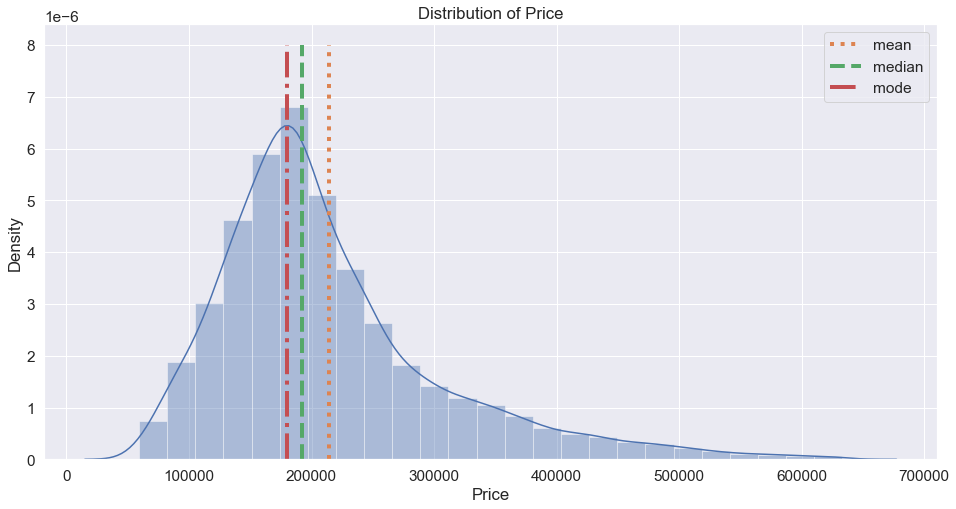

In [139]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=25)

y = np.linspace(0, 0.000008, 10)
plt.plot([df['Price'].mean()] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([df['Price'].median()] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([df['Price'].mode()[0] // 10000 * 10000] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

Среднее значение немного смещено изза ассиметрии в право, однако мода и медиана достаточно близко, и в целом мы видим нормально распределение. Длина хвоста говорит нам, что сильно дорогих кавртир на много больше сильно дешевых.

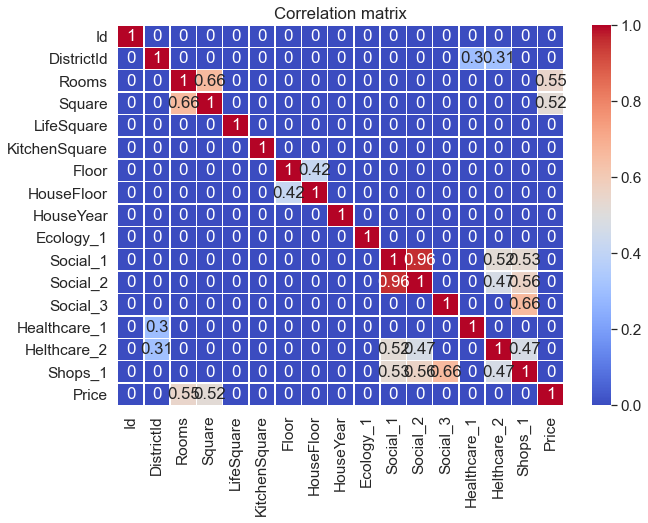

In [140]:
plt.figure(figsize = (10,7))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

#### Разбиваем на трейн и тест

In [141]:
X_train, y_train = df.drop("Price", axis = 1), df["Price"]

In [142]:
X_test = pd.read_csv(TEST_DATASET_PATH)
IKurkov_predictions = pd.DataFrame(X_test['Id']) # для того, чтоб потом можно было получить ID, Price для выгрузки ответов. 

In [143]:
X_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300
std,4859.01902,43.587592,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


##### Первый взгляд на данные.
- Id можно исключить из анализа, т.к. он не несет полезной информации, только индекс. Или использовать вместо индекса строк.
- District т.к. это скорее категориальное значение можно заменить модой
- Rooms 0 врядли верное значение, даже студия считается минимум 1 комнатой. Можно высчитать среднюю площадь на комнату из имеющихся данных и вставлять в 0 значения Lifesquare / среднее площадь и округлить до целого. Также стоит проверить максимальное значеие комнат.
- Square минимальная и максимальная площадь подозрительны
- LifeSquare  также минимальная и максимальное значение подозрительны.
- KitchenSquare таже история с максимальным. 
- Floor вроде все ок
- HouseFloor 0 этажей не может быть. 
- HouseYear перевести год постройки в возвраст дома.
- Ecology_1	Social_1	Social_2	Social_3	Healthcare_1	Helthcare_2	Shops_1 не понятно, что за показатели, так что нужно посмотреть в первую очередь, как можно заполнить НаН значения.



#### Id

In [144]:
X_train = X_train.drop('Id', axis=1)

Уберем признак, т.к. он не информатьивен.

#### DistrictId

In [145]:
X_train['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
196      1
117      1
205      1
199      1
207      1
Name: DistrictId, Length: 205, dtype: int64

В целом наблюдения похожи, так что скорее всего 0 это не выброс, а счет идет с 0 включительно. Т.к. этот признак номинальный, надо его привести к количественному. Как вариант, нормализовать по доли. Таким образом, мы номер района превратим в индекс популярности.

In [146]:
distict_dict = X_train["DistrictId"].value_counts(normalize=True).to_dict()

In [147]:
X_train.replace({"DistrictId": distict_dict}, inplace=True )

In [148]:
X_train["DistrictId"].value_counts()

0.0851    851
0.0652    652
0.0565    565
0.0511    511
0.0097    388
         ... 
0.0021     21
0.0019     19
0.0003     15
0.0002     12
0.0001      7
Name: DistrictId, Length: 90, dtype: int64

#### Rooms

In [149]:
X_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

Хоть по статистике и получается, что 4 и более комнат являются выбросами, но после просмотра данных по этим квартирам становится ясно, что 4 комнаты, это просто большие квартиры, а выбросы это  5 и более комнат.
По этому обработаем выбросы, заменив на ближайшее нормальное значение, и создадим доп признак для выделения изменения.  

In [150]:
X_train["Rooms_outlier"] = 0
X_train.loc[(X_train["Rooms"] >= 5), "Rooms_outlier"] = 1
X_train.loc[(X_train["Rooms"] >= 5), "Rooms"] = 4


#### KitchenSquare

In [151]:
X_train.loc[X_train["KitchenSquare"] > 150, "KitchenSquare"] = X_train["KitchenSquare"].median() # отсечем явно ошибочные значения

#### LifeSquare

Заполняя Нан значения средним или медианой по признаку, получается большой перекос, т.к. пропущенных значений слишком много.  Мы можем расчитать средний коэффициент отношения жилой площади к общей площади, и используя его спрогнозировать пропущенные значения.

In [152]:
X_train["LifeSquare_nan"] = 0
X_train.loc[X_train["LifeSquare"].isnull(), "LifeSquare_nan"] = 1

In [153]:
life_square_coef =  X_train["LifeSquare"].mean() / X_train["Square"].mean()
X_train.loc[X_train["LifeSquare"].isnull(), "LifeSquare"] = X_train.loc[X_train["LifeSquare"].isnull(), "Square"] * life_square_coef

#### Floor

Как правило первый и последний этажи стоят дешевле, можно это пометить.


In [154]:
bad_floor = (X_train["Floor"] == 1) | (X_train["Floor"] == X_train["HouseFloor"])
X_train["Bad_floor"] = 0
X_train.loc[bad_floor, "Bad_floor"] = 1

#### HouseFloor	

In [155]:
X_train.loc[X_train["HouseFloor"] == 0].head(5) # 0 этажей явно ошибка

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,LifeSquare_nan,Bad_floor
7,0.0114,2.0,80.312927,53.051064,0.0,14,0.0,1977,0.075779,B,...,6,1437,3,NaN,0,2,B,0,1,0
23,0.0037,3.0,118.907608,78.544952,0.0,2,0.0,1977,0.006076,B,...,30,5285,0,645.0,6,6,B,0,1,0
26,0.0851,3.0,106.958870,0.641822,0.0,17,0.0,2018,0.072158,B,...,2,629,1,NaN,0,0,A,0,0,0
39,0.0565,2.0,60.503250,39.965691,0.0,16,0.0,1977,0.034656,B,...,0,168,0,NaN,0,0,B,0,1,0
44,0.0036,3.0,104.211395,106.340401,0.0,20,0.0,2017,0.060753,B,...,15,2787,2,520.0,0,7,B,0,0,0


Заменим 0 этажи значением этажа продаваемой квартиры.

In [156]:
X_train["HouseFloor_outlier"] = 0
X_train.loc[X_train["HouseFloor"] == 0, "HouseFloor_outlier"] = 1
X_train.loc[X_train["HouseFloor"] == 0, "HouseFloor"] = X_train.loc[X_train["HouseFloor"] == 0, "Floor"]

#### HouseYear

Переведем год постройки в возраст дома.

In [157]:
from datetime import datetime
x = datetime.now()
X_train.loc[X_train["HouseYear"] > x.year, "HouseYear"] = X_train["HouseYear"].median()
X_train["HouseYear"] = x.year - X_train["HouseYear"]


<AxesSubplot:>

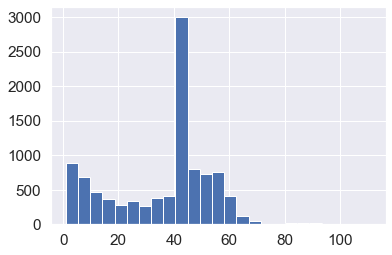

In [158]:
X_train["HouseYear"].hist(bins=25)

In [159]:
X_train["HouseYear"].value_counts()

44     2654
4       308
5       305
6       299
7       210
       ... 
107       1
93        1
74        1
105       1
111       1
Name: HouseYear, Length: 95, dtype: int64

Явно выделяются дома которым 44 года.

In [160]:
X_train['Ecology_2'] = (X_train['Ecology_2'] == 'A').astype(int)
X_train['Ecology_3'] = (X_train['Ecology_3'] == 'A').astype(int)
X_train['Shops_2'] = (X_train['Shops_2'] == 'A').astype(int)

#### Healthcare_1 

--- Начало Healthcare_1 ---

Спрогнозируем Нан значения через модель.

In [161]:
X_train_H = X_train.loc[X_train['Healthcare_1'].notnull()]
y_2 = X_train_H["Healthcare_1"]
X_train_H = X_train_H.drop(['Healthcare_1'], axis = 1)

In [162]:
gb_model2 = GradientBoostingRegressor(criterion='mse', min_samples_leaf=10, random_state=42, max_depth = 5, max_features=6, n_estimators=200)
gb_model2.fit(X_train_H, y_2)

GradientBoostingRegressor(criterion='mse', max_depth=5, max_features=6,
                          min_samples_leaf=10, n_estimators=200,
                          random_state=42)

In [163]:
X_nan_healthcare_1 = (X_train.loc[X_train['Healthcare_1'].isnull()]).drop('Healthcare_1', axis = 1)
y_pred_healthcare_1 = gb_model2.predict(X_nan_healthcare_1)
X_train.loc[X_train['Healthcare_1'].isnull(), 'Healthcare_1'] = y_pred_healthcare_1

--- Конец Healthcare_1 ---

In [164]:
X_train.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Rooms_outlier', 'LifeSquare_nan', 'Bad_floor',
       'HouseFloor_outlier'],
      dtype='object')

In [165]:
from sklearn.decomposition import PCA

In [166]:
scaler = RobustScaler()

In [167]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)


In [168]:
X_ecology = X_train_scaled[['Ecology_1', 'Ecology_2', 'Ecology_3']]

pca = PCA(n_components=1, random_state=42)
X_train['Ecology'] = pca.fit_transform(X_ecology)

In [169]:
X_healthcare = X_train_scaled[['Healthcare_1', 'Helthcare_2']]
pca = PCA(n_components=1, random_state=42)
X_train['Healthcare'] = pca.fit_transform(X_healthcare)

In [170]:
X_social = X_train_scaled[['Social_1', 'Social_2', 'Social_3']]
pca = PCA(n_components=1, random_state=42)
X_train['Social'] = pca.fit_transform(X_social)

In [171]:
X_shops = X_train_scaled[['Shops_1', 'Shops_2']]

pca = PCA(n_components=1, random_state=42)
X_train['Shops'] = pca.fit_transform(X_shops)


In [120]:
X_train = X_train[['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Rooms_outlier', 'LifeSquare_nan', 'Bad_floor',
       'HouseFloor_outlier', 'Ecology', 'Healthcare', 'Social', 'Shops']]

### Подготавливаем тестовый сет

In [121]:

medians = X_train["KitchenSquare"].median(), X_train["HouseYear"].median()

In [122]:
def x_test_prepare(X_test_prepare, medians):

    
    kitchenSquare, houseyear = medians
    
    X_test_prepare = X_test_prepare.drop('Id', axis=1)
    X_test_prepare.replace({"DistrictId": distict_dict}, inplace=True )
   
    X_test_prepare["Rooms_outlier"] = 0
    X_test_prepare.loc[(X_test_prepare["Rooms"] >= 5), "Rooms_outlier"] = 1
    X_test_prepare.loc[(X_test_prepare["Rooms"] >= 5), "Rooms"] = 4
    
    X_test_prepare.loc[X_test_prepare["KitchenSquare"] > 150, "KitchenSquare"] = kitchenSquare
    
    
    X_test_prepare["LifeSquare_nan"] = 0
    X_test_prepare.loc[X_test_prepare["LifeSquare"].isnull(), "LifeSquare_nan"] = 1
    X_test_prepare.loc[X_test_prepare["LifeSquare"].isnull(), "LifeSquare"] = X_test_prepare.loc[X_test_prepare["LifeSquare"].isnull(), "Square"] * life_square_coef
    
    X_test_bad_floor = (X_test_prepare["Floor"] == 1) | (X_test_prepare["Floor"] == X_test_prepare["HouseFloor"])
    X_test_prepare["Bad_floor"] = 0
    X_test_prepare.loc[X_test_bad_floor, "Bad_floor"] = 1
    

    X_test_prepare["HouseFloor_outlier"] = 0
    X_test_prepare.loc[X_test_prepare["HouseFloor"] == 0, "HouseFloor_outlier"] = 1
    X_test_prepare.loc[X_test_prepare["HouseFloor"] == 0, "HouseFloor"] = X_test_prepare.loc[X_test_prepare["HouseFloor"] == 0, "Floor"]
    
    x = datetime.now()
    X_test_prepare.loc[X_test_prepare["HouseYear"] > x.year, "HouseYear"] = houseyear
    X_test_prepare["HouseYear"] = x.year - X_test_prepare["HouseYear"]
    
    
    X_test_prepare['Ecology_2'] = (X_test_prepare['Ecology_2'] == 'A').astype(int)
    X_test_prepare['Ecology_3'] = (X_test_prepare['Ecology_3'] == 'A').astype(int)
    X_test_prepare['Shops_2'] = (X_test_prepare['Shops_2'] == 'A').astype(int) 
    
    
    X_nan_healthcare_1 = (X_test_prepare.loc[X_test_prepare['Healthcare_1'].isnull()]).drop('Healthcare_1', axis = 1)
    y_pred_healthcare_1 = gb_model2.predict(X_nan_healthcare_1)
    X_test_prepare.loc[X_test_prepare['Healthcare_1'].isnull(), 'Healthcare_1'] = y_pred_healthcare_1
    
    
    X_test_prepare_scaled = pd.DataFrame(scaler.transform(X_test_prepare), columns=X_test_prepare.columns)
    
    X_test_ecology = X_test_prepare_scaled[['Ecology_1', 'Ecology_2', 'Ecology_3']]
    pca = PCA(n_components=1, random_state=42)
    X_test_prepare['Ecology'] = pca.fit_transform(X_test_ecology)
    
    X_test_healthcare = X_test_prepare_scaled[['Healthcare_1', 'Helthcare_2']]
    pca = PCA(n_components=1, random_state=42)
    X_test_prepare['Healthcare'] = pca.fit_transform(X_test_healthcare)
    
    X_test_social = X_test_prepare_scaled[['Social_1', 'Social_2', 'Social_3']]
    pca = PCA(n_components=1, random_state=42)
    X_test_prepare['Social'] = pca.fit_transform(X_test_social)
    
    X_test_shops = X_test_prepare_scaled[['Shops_1', 'Shops_2']]
    pca = PCA(n_components=1, random_state=42)
    X_test_prepare['Shops'] = pca.fit_transform(X_test_shops)
    
    X_test_prepare = X_test_prepare[['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Rooms_outlier', 'LifeSquare_nan', 'Bad_floor',
       'HouseFloor_outlier', 'Ecology', 'Healthcare', 'Social', 'Shops']]
   
    return X_test_prepare

In [123]:
X_test = x_test_prepare(X_test, medians)

### Обучаем модель

Подбор гиперпараметров

{'max_depth': 5, 'max_features': 6, 'min_samples_leaf': 8, 'n_estimators': 350}

#### Финальная модель

In [124]:
gb_model = GradientBoostingRegressor(criterion='mse', min_samples_leaf=8, random_state=42, max_depth = 5, max_features=6, n_estimators=350)

In [125]:
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, max_features=6,
                          min_samples_leaf=8, n_estimators=350,
                          random_state=42)

In [126]:
y_pred = gb_model.predict(X_train)

In [127]:
def evaluate_preds(true_values, pred_values, save=False):
        
    print("R2:\t" + str(round(r2(true_values, pred_values), 4)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    plt.show()

### Итоговый результат

R2:	0.8928
RMSE:	30409.665
MSE:	924747748.896


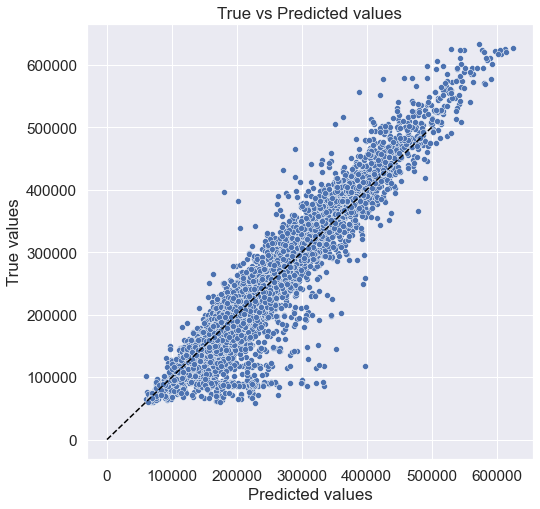

In [128]:
evaluate_preds(y_train, y_pred)


In [129]:
f_i = gb_model.feature_importances_

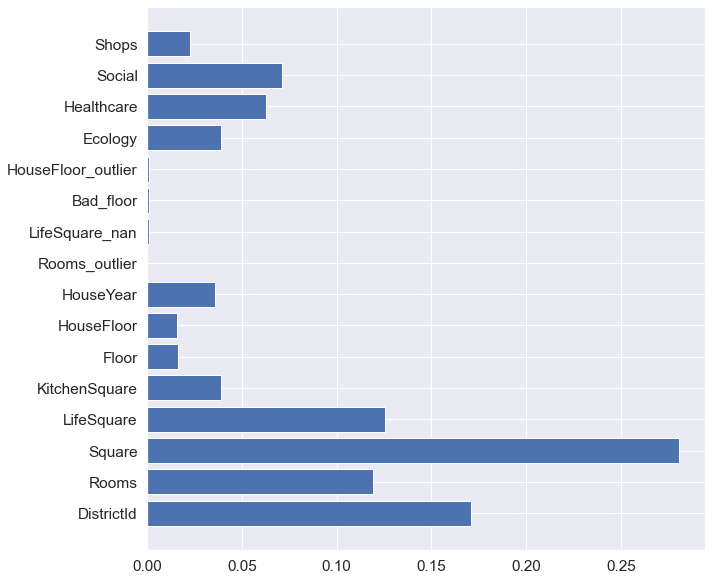

In [130]:
plt.figure(figsize=(10,10))
plt.barh(X_train.columns, f_i)
plt.show()

Манипуляции с DistrictId, Healthcare_1, LifeSquare оправдались, получились сильные признаки.

In [131]:
y_test_pred = gb_model.predict(X_test)

In [132]:
IKurkov_predictions["Price"] = y_test_pred

In [133]:
IKurkov_predictions

,Id,Price
0,725,162505.095970
1,15856,213363.124046
2,5480,185397.058954
3,15664,303229.904097
4,14275,151717.791032
...,...,...
4995,8180,228102.126781
4996,4695,109752.448589
4997,5783,367770.799424
4998,4780,182853.274915
